In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
import math
import matplotlib.patches as patches
import time

In [2]:
import importlib  

module = importlib.import_module('0) APIs')
detect_and_refine_boundingBox = module.detect_and_refine_boundingBox

In [3]:
from os import listdir
from os.path import isfile, join
images_paths = [f for f in listdir('../images') if isfile(join('../images', f))]

Text(0.5, 1.0, 'Original image')

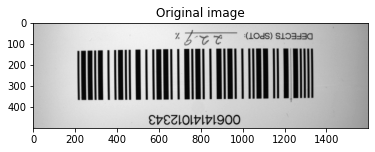

In [4]:
image_path = f'../images/{images_paths[18]}'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   

plt.figure()
plt.imshow(gray, 'gray')
plt.title('Original image')  

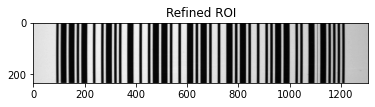

In [5]:
roi_image, bb_points_sorted_rot, bb_width, bb_height = detect_and_refine_boundingBox(image, 
                            use_same_threshold=False, compute_barcode_structure_algorithm=1, verbose_timing=False,
                            outlier_detection_level=0.02, visualization_dict={'visualize_refined_roi':True})

## COMPUTING THE SCAN LINE

In [6]:
bb_height

233

In [7]:
scanlines_indices = np.linspace(start=0, stop=bb_height, num=12, dtype=int)[1:-1]
scanlines_indices

array([ 21,  42,  63,  84, 105, 127, 148, 169, 190, 211])

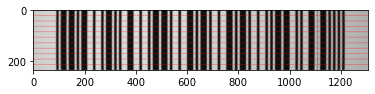

In [8]:
roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanlines_indices,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

## NORMALIZING THE IMAGE

In [9]:
roi_image_norm = roi_image/255

In [44]:
roi_image_norm = np.rint(100*(roi_image/255))

## COMPUTING THE PARAMETERS ON ONE SCANLINE
We focus on one scanline, and we compute the parameters.

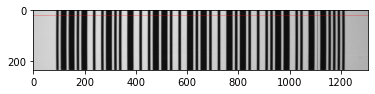

In [45]:
scanline_index = scanlines_indices[0]#math.ceil(bb_height/2)

roi_image_tmp = roi_image.copy()
roi_image_tmp = cv2.cvtColor(roi_image_tmp, cv2.COLOR_GRAY2RGB)
roi_image_tmp[scanline_index,:,:] = np.array([255,0,0])
plt.figure()
plt.imshow(roi_image_tmp, 'gray') 

In [46]:
scanline = roi_image_norm[scanline_index, :]

Text(0.5, 1.0, 'Scan reflectance profile')

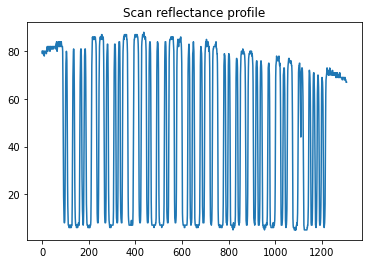

In [47]:
plt.plot(scanline)
plt.title('Scan reflectance profile')

In [48]:
R_min = scanline.min()
R_max = scanline.max()

In [49]:
R_min, R_max

(5.0, 88.0)

In [50]:
SC = R_max - R_min
SC

83.0

In [51]:
GB = R_min + SC/2
GB

46.5

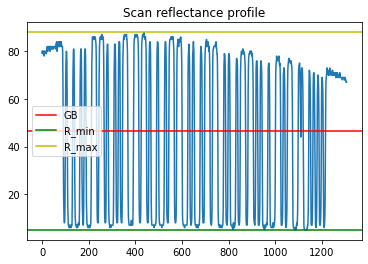

In [52]:
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.axhline(R_min, c='g', label='R_min')
plt.axhline(R_max, c='y', label='R_max')
plt.title('Scan reflectance profile')
plt.legend()

The wrong black line within a space can be noticed.

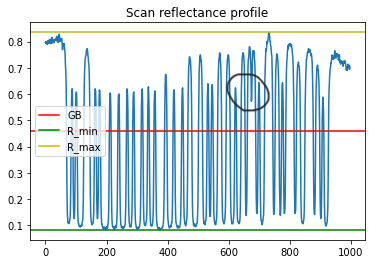

In [53]:
mask = (scanline<GB).astype(int)
print(mask)
print()
mask_1 = np.append([0],mask[:-1])
print(mask_1) 

[0 0 0 ... 0 0 0]

[0 0 0 ... 0 0 0]


In [54]:
edges_mask = (mask - mask_1).astype(bool)
edges_mask

array([False, False, False, ..., False, False, False])

In [55]:
np.indices((mask.shape[0],))

array([[   0,    1,    2, ..., 1304, 1305, 1306]])

In [56]:
edges_first_indices = np.indices(mask.shape)[0][edges_mask]
edges_first_indices

array([  91,  100,  108,  131,  139,  162,  171,  180,  189,  212,  234,
        244,  266,  276,  284,  308,  317,  327,  336,  345,  368,  392,
        415,  425,  448,  458,  467,  491,  501,  525,  534,  544,  567,
        577,  601,  625,  634,  645,  654,  678,  687,  697,  721,  731,
        754,  779,  788,  798,  807,  831,  840,  850,  873,  884,  907,
        917,  926,  936,  944,  969,  977, 1001, 1024, 1034, 1042, 1053,
       1075, 1099, 1109, 1111, 1120, 1144, 1152, 1162, 1170, 1181, 1188,
       1199, 1206, 1216])

<IPython.core.display.Javascript object>


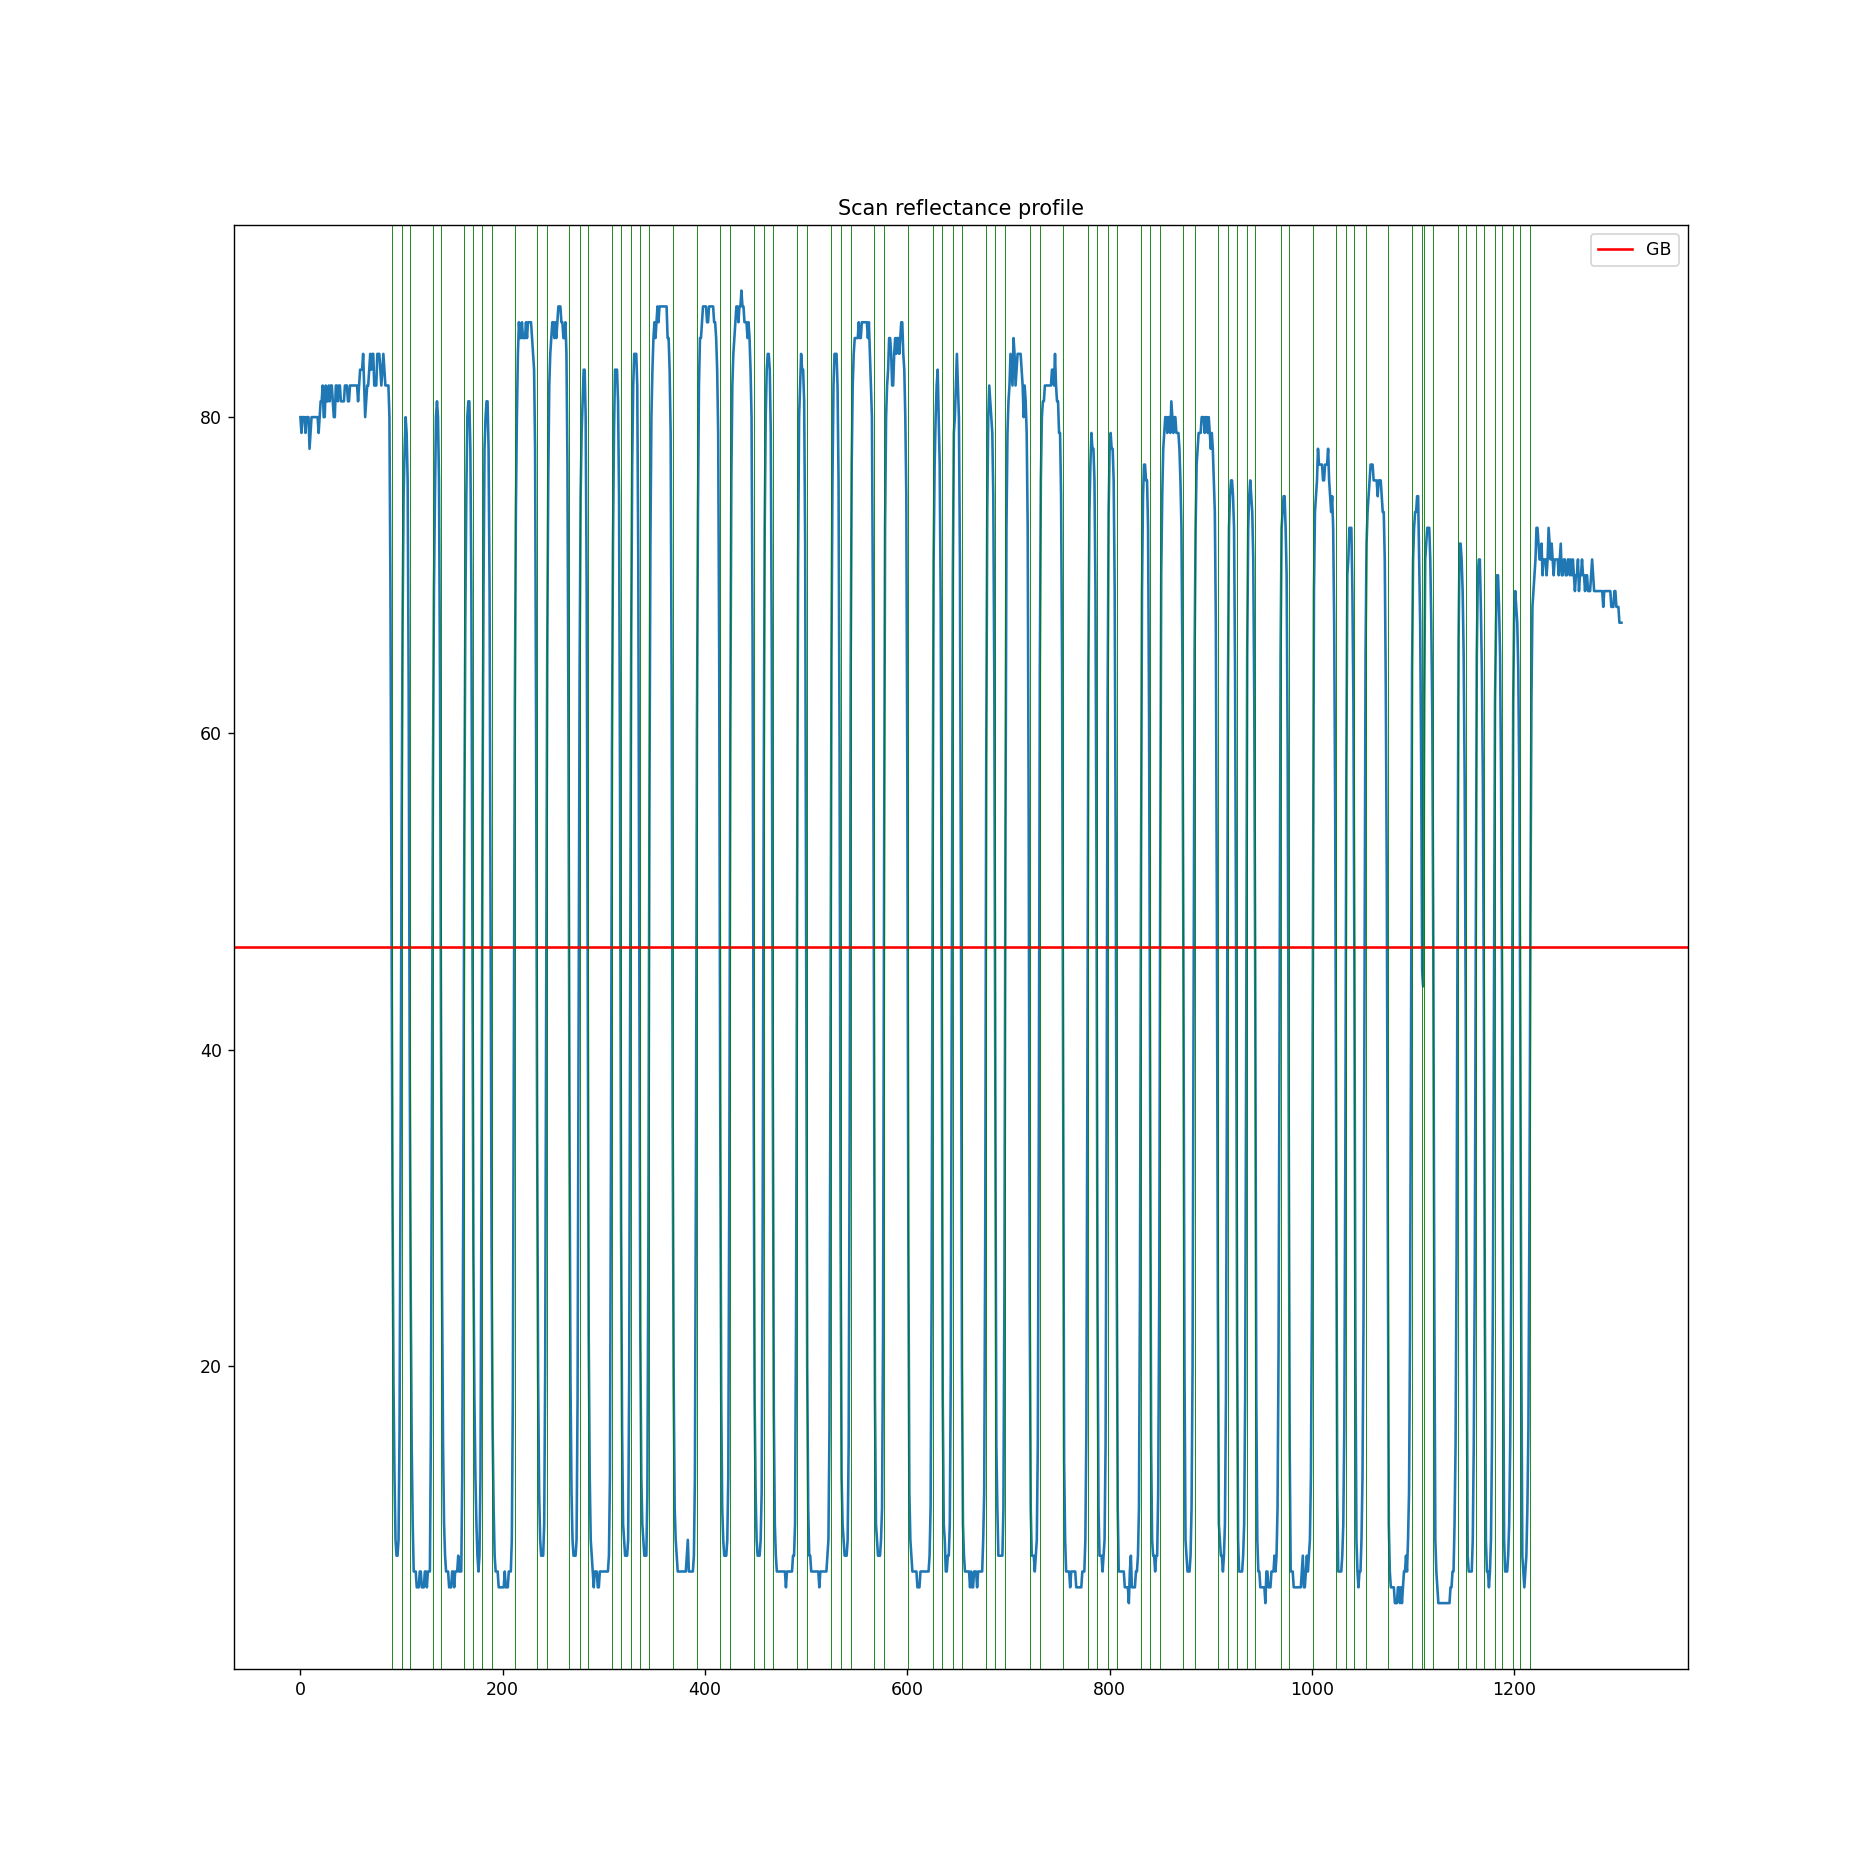

In [57]:
%matplotlib notebook
plt.figure(figsize=(15,15))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
for i in edges_first_indices:
    plt.axvline(i, c='g', lw=0.5)
plt.title('Scan reflectance profile')
plt.legend()

In [58]:
ERN_list = []
element = scanline[:edges_first_indices[0]]
ERN_list.append(element.max()-element.min())
for i, edge_first_index in enumerate(edges_first_indices): 
    if i>=len(edges_first_indices)-1:
        element = scanline[edge_first_index:]
    else:
        element = scanline[edge_first_index:edges_first_indices[i+1]]
    ERN_list.append(element.max()-element.min())
    
ERN_max = max(ERN_list)

DEFECTS = ERN_max / SC

DEFECTS

0.4939759036144578

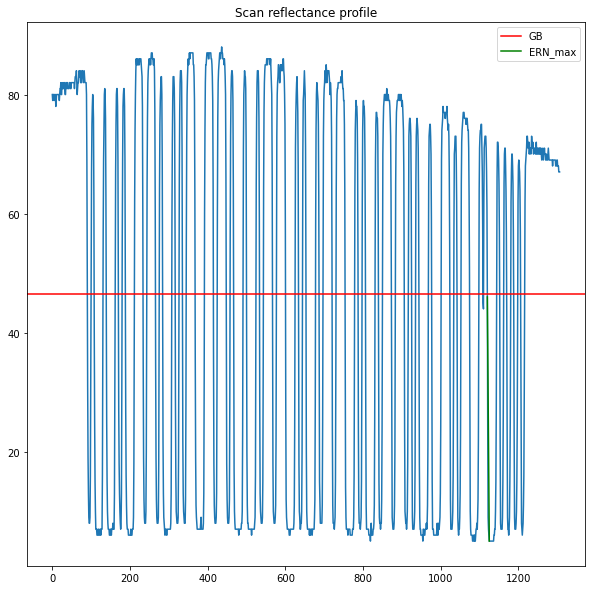

In [59]:
# Visualize ERN_max
ERN_max_edge_index = np.argmax(ERN_list)
if ERN_max_edge_index==0:
    element = scanline[:edges_first_indices[0]]
    element_first_index = 0
elif ERN_max_edge_index<len(ERN_list)-1:
    element = scanline[edges_first_indices[ERN_max_edge_index-1]:edges_first_indices[ERN_max_edge_index]]
    element_first_index = edges_first_indices[ERN_max_edge_index-1]
else:
    element = scanline[edges_first_indices[ERN_max_edge_index-1]:]
    element_first_index = edges_first_indices[ERN_max_edge_index-1]
    
max_index = np.argmax(element) + element_first_index
max_value = np.max(element)
min_index = np.argmin(element) + element_first_index
min_value = np.min(element)

%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(scanline)
plt.axhline(GB, c='r', label='GB')
plt.plot([min_index, max_index], [min_value, max_value], c='g', label='ERN_max')
plt.title('Scan reflectance profile')
plt.legend()

In [60]:
scanline[max_index]

46.0

In [61]:
GB

46.5